# Full Synthesis Testing

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from numpy.random import default_rng

In [2]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    full_X["age"] = full_X["age"].astype('category')
    
    age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
    age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    full_X = full_X.drop("age", axis=1)
    
    full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
    full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty='none', max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = (full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [3]:
# import standardized lat/long location data
X = pd.read_csv("Data/cleaned_data.csv")
N = X.shape[0]

Number of locations.

In [4]:
N

6712

Number of locations from deceased individuals.

In [5]:
np.sum(X.state)

55

Split dataset into continuous and categorical variables.

In [6]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,male,50s,0
1,0.889746,-0.694899,male,50s,0
2,0.917482,-0.682299,male,30s,0
3,0.916660,-0.682551,male,30s,0
4,0.886074,-0.668883,male,30s,0
...,...,...,...,...,...
6707,0.881500,-0.925307,male,40s,0
6708,-1.728784,1.470871,male,40s,0
6709,-1.548071,1.557316,male,40s,0
6710,-1.549392,1.555785,male,40s,0


In [7]:
cat_columns = X.select_dtypes(['object']).columns

In [8]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [9]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [10]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [12]:
np.mean(X.sex)

0.4620083432657926

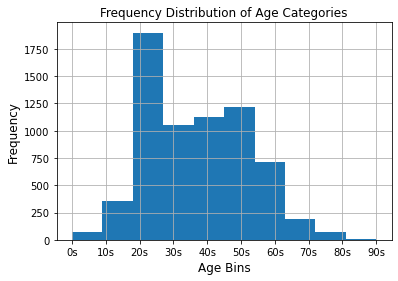

In [13]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(labels=categories['age'])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

# Full Sequential Synthesis Driven by Bayesian Optimization

Function to be used in Bayesian bootstrap.

In [ ]:
def stat(x):
    return x

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [ ]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 ccp_alpha_sex_,
                 ccp_alpha_age_,
                 ccp_alpha_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(ccp_alpha=ccp_alpha_sex_)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                   statistic=stat,
                                   n_replications=1,
                                   resample_size=len(x))[0] for x in node_outcomes]
    
    probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.sex)] for y in bst_vals]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = np.random.binomial(n=1, p=probs[j][1], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(ccp_alpha=ccp_alpha_age_)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                   statistic=stat,
                                   n_replications=1,
                                   resample_size=len(x))[0] for x in node_outcomes]
    
    probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.age)] for y in bst_vals]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            draws = np.random.multinomial(n=1, pvals=probs[j], size=np.sum(synth_leaves==x))
            
            draws = np.argmax(draws, axis=1)
            
            new_age[synth_leaves==x] = draws
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(ccp_alpha=ccp_alpha_state_)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                   statistic=stat,
                                   n_replications=1,
                                   resample_size=len(x))[0] for x in node_outcomes]
    
    probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.state)] for y in bst_vals]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = np.random.binomial(n=1, p=probs[j][1], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM, cart_sex, cart_age, cart_state

In [ ]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, ccp_alpha_sex_, ccp_alpha_age_, ccp_alpha_state_):

        pmse_ratios, _, _, _, _, _ = train_models(train_data=train_data,
                                                  number_synthetic_datasets=number_synthetic_datasets,
                                                  number_gmm_initializations=number_gmm_initializations,
                                                  num_components_=int(num_components_),
                                                  ccp_alpha_sex_=ccp_alpha_sex_,
                                                  ccp_alpha_age_=ccp_alpha_age_,
                                                  ccp_alpha_state_=ccp_alpha_state_)

        return -np.mean([(1 - x)**2 for x in pmse_ratios])
    
    bounds_transformer = SequentialDomainReductionTransformer()

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "ccp_alpha_sex_": (1e-9, 1e-3),
            "ccp_alpha_age_": (1e-9, 1e-3),
            "ccp_alpha_state_": (1e-9, 1e-3)
        },
        random_state=random_state)

    optimizer.maximize(n_iter=1, acq='ei', xi=1e-2)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

In [ ]:
nsd = 5
ngi = 1
random_states = [1234, 4321, 10620, 91695, 31296]

In [ ]:
optimization_results = [optimize_models(train_data=X, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

***

In [ ]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [ ]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [ ]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

***

Generate 100 synthetic datasets, choose the 20 that have the pMSE closest to 1.

In [ ]:
ratios, sXs, GMM, cart_sex, cart_age, cart_state = train_models(train_data=X,
                                                                number_synthetic_datasets=100,
                                                                # hyperparameters for GMM
                                                                number_gmm_initializations=ngi,
                                                                num_components_=100,#int(best_params['params']['num_components_']),
                                                                # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                                                ccp_alpha_sex_=best_params['params']['ccp_alpha_sex_'],
                                                                ccp_alpha_age_=best_params['params']['ccp_alpha_age_'],
                                                                ccp_alpha_state_=best_params['params']['ccp_alpha_state_'])

In [ ]:
indices = np.argsort([np.abs(1-r) for r in ratios])#[:20]

In [ ]:
sXs = [sXs[i] for i in indices]

In [ ]:
ratios = [ratios[i] for i in indices]

In [ ]:
np.exp(np.log(ratios).mean())

In [ ]:
np.mean([np.abs(1 - x) for x in ratios])

In [ ]:
plt.violinplot(ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

Testing logistic and multinomial logistic regression synthesizers.

In [14]:
def polynomial_and_standardize(dataset, poly_degree=2, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [15]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=2, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial')
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    for Y in sXs:
    
        probs = mn_model.predict_proba(Y)
    
        rng = default_rng()
    
        v = [np.argmax(rng.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [16]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [17]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)

        return -np.mean([(1 - x)**2 for x in pmse_ratios])
    
    bounds_transformer = SequentialDomainReductionTransformer()

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.1, 1),
            "C_age_": (0.1, 1),
            "C_state_": (0.1, 1)
        },
        random_state=random_state)

    optimizer.maximize(acq='ei', xi=1e-2)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

In [18]:
nsd = 20
ngi = 5
random_states = [1234, 4321, 10620, 91695, 31296]

In [19]:
optimization_results = [optimize_models_mn(train_data=X, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
|  1        | -0.2177   |  0.2724   |  0.6599   |  0.494    |  672.0    |
|  2        | -0.2011   |  0.802    |  0.3453   |  0.3488   |  681.9    |
|  3        | -0.127    |  0.9623   |  0.8883   |  0.422    |  501.1    |
|  4        | -0.1574   |  0.7151   |  0.7414   |  0.4332   |  537.3    |
|  5        | -0.182    |  0.5528   |  0.1124   |  0.7955   |  730.5    |
|  6        | -0.4979   |  0.1909   |  0.369    |  0.5124   |  480.3    |
|  7        | -0.1898   |  0.6266   |  0.2079   |  0.6768   |  506.2    |
|  8        | -0.083    |  0.9165   |  0.3963   |  0.8929   |  546.1    |
|  9        | -0.676    |  0.1      |  1.0      |  0.1      |  552.5    |
|  10       | -0.1469   |  0.5058   |  0.2281   |  0.7857   |  545.3    |
|  11       | -0.2783   |  0.2677   |  0.9087   |  0.9608   |  547.0    |
|  12       | -0.2589   |  1.0      | 

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


|  2        | -0.2474   |  0.2738   |  0.981    |  0.4656   |  655.4    |
|  3        | -0.3644   |  0.1802   |  0.3789   |  0.657    |  476.4    |
|  4        | -0.1933   |  0.2965   |  0.6972   |  0.7108   |  771.1    |
|  5        | -0.243    |  0.3531   |  0.6579   |  0.445    |  440.6    |
|  6        | -0.3878   |  0.2015   |  0.1249   |  0.2732   |  771.1    |
|  7        | -0.1296   |  0.7855   |  0.7889   |  0.8925   |  395.6    |
|  8        | -0.09227  |  0.4576   |  0.7102   |  0.5673   |  325.4    |
|  9        | -0.1975   |  0.361    |  0.7156   |  0.6818   |  325.2    |
|  10       | -0.1597   |  0.9808   |  0.781    |  0.8065   |  291.3    |
|  11       | -0.1936   |  0.9957   |  0.7495   |  0.7725   |  576.7    |
|  12       | -0.2292   |  0.2019   |  0.7412   |  0.4541   |  325.4    |
|  13       | -0.3039   |  0.1649   |  0.6421   |  0.4599   |  332.8    |
|  14       | -0.2831   |  0.4251   |  0.2416   |  0.9284   |  230.5    |
|  15       | -0.148    |  0.8753   | 

|  3        | -0.1092   |  0.5803   |  0.7655   |  0.9193   |  416.8    |
|  4        | -0.4201   |  0.1397   |  0.8264   |  0.6895   |  560.9    |
|  5        | -0.09781  |  0.6264   |  0.2479   |  0.8329   |  541.5    |
|  6        | -0.2059   |  0.4531   |  0.8109   |  0.2995   |  409.5    |
|  7        | -0.1145   |  0.9835   |  0.8045   |  0.7711   |  423.1    |
|  8        | -0.1363   |  0.8729   |  0.9116   |  0.3791   |  530.5    |
|  9        | -0.3199   |  0.3722   |  0.1979   |  0.9663   |  435.9    |
|  10       | -0.152    |  0.6033   |  0.1291   |  0.8428   |  519.2    |
|  11       | -0.1031   |  0.6489   |  0.8494   |  0.6701   |  505.7    |
|  12       | -0.3431   |  0.3196   |  0.3298   |  0.1387   |  497.9    |
|  13       | -0.1308   |  0.6165   |  0.9178   |  0.365    |  509.6    |
|  14       | -0.221    |  0.4705   |  0.1533   |  0.1157   |  544.7    |
|  15       | -0.1825   |  0.3634   |  0.3533   |  0.5489   |  570.2    |
|  16       | -0.2477   |  0.3184   | 

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


|  22       | -0.495    |  0.6903   |  0.5159   |  0.1017   |  755.1    |
|  23       | -0.1158   |  0.8689   |  0.4069   |  0.8996   |  599.6    |
|  24       | -0.3887   |  0.4278   |  0.5183   |  0.5205   |  210.4    |
|  25       | -0.1933   |  0.7156   |  0.5825   |  0.7354   |  599.4    |
|  26       | -0.1202   |  0.8809   |  0.6811   |  0.8297   |  600.1    |
|  27       | -0.1535   |  0.7482   |  0.436    |  0.8938   |  600.0    |
|  28       | -0.5578   |  0.1196   |  0.9598   |  0.4678   |  616.5    |
|  29       | -0.1856   |  0.9324   |  0.3506   |  0.4051   |  600.3    |
|  30       | -0.1726   |  0.7731   |  0.5873   |  0.6796   |  488.9    |
Final Result:  {'target': -0.1157601262839214, 'params': {'C_age_': 0.8689152950540625, 'C_sex_': 0.40693053732515205, 'C_state_': 0.899594638032717, 'num_components_': 599.6135906866062}}


In [20]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

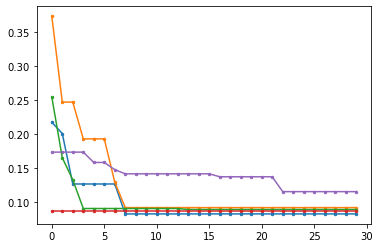

In [21]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [22]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [23]:
best_params

{'target': -0.08300395541536003,
 'params': {'C_age_': 0.9165392293820231,
  'C_sex_': 0.3962963449448256,
  'C_state_': 0.8929264200392774,
  'num_components_': 546.1255695944657}}

***

Generate 100 synthetic datasets, choose the 20 that have the pMSE closest to 1.

In [24]:
ratios, sXs, GMM = train_models_mn(train_data=X,
                                   number_synthetic_datasets=100,
                                   # hyperparameters for GMM
                                   number_gmm_initializations=ngi,
                                   num_components_=int(best_params['params']['num_components_']),
                                   # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                   C_sex_=best_params['params']['C_sex_'],
                                   C_age_=best_params['params']['C_age_'],
                                   C_state_=best_params['params']['C_state_'])

In [25]:
num_keep = 20

In [26]:
indices = np.argsort([np.abs(1-r) for r in ratios])[:num_keep]

In [27]:
sXs = [sXs[i] for i in indices]

In [28]:
ratios = [ratios[i] for i in indices]

In [29]:
np.exp(np.log(ratios).mean())

1.0262004521767911

In [30]:
np.mean([np.abs(1 - x) for x in ratios])

0.04584527979155882

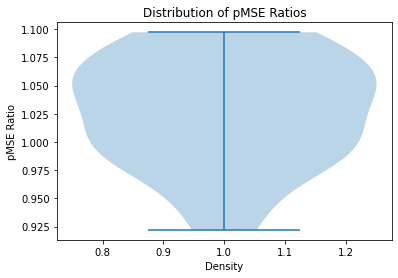

In [31]:
plt.violinplot(ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

Show side-by-side comparisons of pMSE ratio plots.

***

# Save the synthetic datasets.

In [32]:
for i, sX in enumerate(sXs):
    sX.to_csv("Data/synthetic_datasets/synthetic_dataset_" + str(i) + ".csv", index=False)

In [33]:
# sXs = [pd.read_csv("Data/synthetic_datasets/synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

In [34]:
## temporary to reduce testing time
# sXs = sXs[:3]

***

# Singling Out Evaluation #1

Are there any synthetic records exactly equal to confidential records. Return their indices if so.

In [35]:
# def any_identical(original_data, synthetic_data):
    
#     # boolean vector for whether any synthetic row matches an original row
#     identical = [(synthetic_data == row).all(1).any() for _,row in original_data.iterrows()]
    
#     # number of original rows with identical synthetic rows
#     num_identical = np.sum(identical)
    
#     # indices of original rows with identical synthetic rows
#     indices = np.flatnonzero(identical)
    
#     return num_identical, indices

Evaluate whether any confidential records were replicated.

In [36]:
# [any_identical(X, Y) for Y in sXs]

# Singling Out Evaluation #2

In order to evaluate the second singling out condition, we need to define an appropriate distance metric.

Quick et al. (2015) define spatially close to be when two points have locations that have a distance $d \le \epsilon_s$. Having similar attributes is similarly defined as having identical categorical attributes and non-categorical marks are within a distance $d \le \epsilon_a$.

We take a similar approach, and will measure distance based on matching categorical attributes, and euclidean distance between the latitude/longitude vectors. This can be used to define a neighborhood near each confidential record with matching categorical attributes and closely similar locations.

In [37]:
from scipy.spatial import cKDTree

Define a sequence of $\delta$ values.

In [38]:
from numpy import ogrid

In [39]:
num_deltas = 20

In [40]:
deltas = np.geomspace(0.00001, 1.1, num=num_deltas)

In [41]:
def neighbor_finder(original_data, synthetic_data, deltas):
    
    full_matches = []
    
    # tree for original locations
    orig_tree = cKDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = cKDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the number of matches for each original row and the indices of those matches
        matches = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age', 'state']] == row[['sex', 'age', 'state']]).all(1)
        
            # store number of matches and their indices
            matches.append(np.sum(categorical_matches))
            
        full_matches.append(pd.Series(matches))
    
    print("Dataset completed.")
    
    return full_matches

In [42]:
neighborhood_stats = [neighbor_finder(X, Y, deltas) for Y in sXs]

neighborhood_stats is nested as one list of match lists for each synthetic dataset, and each of those lists consists of twenty lists, one for each value of delta.

Build an $n \times num\_delta \times m$ dataframe for match numbers.

In [43]:
match_nums = [pd.concat(x, axis=1) for x in neighborhood_stats]

In [44]:
match_nums = np.dstack(match_nums)

Calculate the number of singled-out records based on each synthetic dataset and each value of $\delta$. Rows are $\delta$ values and columns are synthetic datasets.

In [45]:
pct_singled_out = np.sum(match_nums == 1.0, axis=0)/X.shape[0]

In [46]:
avg_pct_singled_out = np.mean(pct_singled_out, axis=1)

In [47]:
delta_id = np.argmax(avg_pct_singled_out)

In [48]:
target_delta = deltas[delta_id]

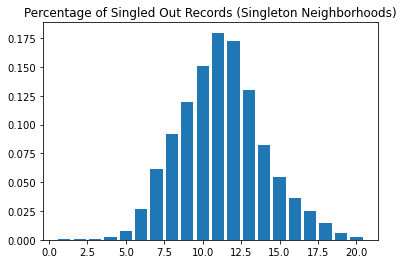

In [49]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_singled_out, align='center')
plt.title("Percentage of Singled Out Records (Singleton Neighborhoods)")
plt.show()

# Linkability Evaluation

Write a function(s) to evaluate the Linkability risk using the same $\delta$ neighborhoods as before.

What are the requirements for $k$-anonymity given by organizations? E.g., I think Japan might have said 22, EMA might have their own requirement. We could look at the percentage of records for which those requirements are met based on each synthetic dataset.

For now, let's set a cutoff of 2 neighbors.

In [50]:
cutoff = 2

Now, calculate the percentage of records that meet the cutoff on average for each value of $\delta$.

In [51]:
meet_cutoff = [[pd.concat([x == 0, x >= cutoff], axis=1).any(axis=1) for x in y] for y in neighborhood_stats]

In [52]:
meet_cutoff = [pd.concat(x, axis=1) for x in meet_cutoff]

In [53]:
meet_cutoff = np.dstack(meet_cutoff)

In [54]:
pct_meet_cutoff = np.mean(meet_cutoff, axis=0)

In [55]:
avg_pct_meet_cutoff = pct_meet_cutoff.mean(axis=1)

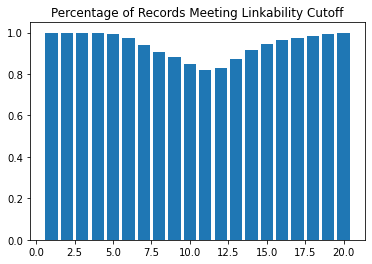

In [56]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_meet_cutoff, align='center')
plt.title("Percentage of Records Meeting Linkability Cutoff")
plt.show()

In [57]:
np.min(avg_pct_meet_cutoff)

0.820277115613826

# Inference Evaluation

Let's start with the adversary's prior. As of March 22, 2020, their were 8897 confirmed COVID-19 cases and 104 deaths. These statistics could be collected from the World Health Organization, and would represent a much more informative prior than a naive uniform prior. Furthermore, evaluating the naive prior would create problems when trying to prevent inference on individuals who did not pass away from COVID.

In [58]:
prior_death_prob = 104/8897

In [59]:
1/0.988

1.0121457489878543

We need to evaluate the inference condition for each record in the confidential data based on each synthetic dataset.

In [60]:
def inference_evaluation(original_data, synthetic_data, prior_prob, deltas):
    
    full_inf_conds = []
    full_indices = []
    
    # tree for original locations
    orig_tree = cKDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = cKDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the inference condition for each original row and the indices of those rows that violate
        inf_conds = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age']] == row[['sex', 'age']]).all(1)
            
            matching_rows = synthetic_data.loc[location_neighbors[i],:].loc[categorical_matches.values,:]
            
            if matching_rows.shape[0] > 0:
                
                if row['state'] == 1.0:
                    prior = prior_prob
                else:
                    prior = 1 - prior_prob
            
                cond = np.mean(matching_rows['state'] == row['state'])/prior
                
            else:
                
                cond = 1
        
            # store number of matches and their indices
            inf_conds.append(cond)
        
        inf_conds = pd.Series(inf_conds)
        
        full_inf_conds.append(inf_conds)
        
    print("Dataset completed.")
        
    return full_inf_conds

In [61]:
inference_conditions = [inference_evaluation(X, Y, prior_death_prob, deltas) for Y in sXs]

In [ ]:
inf_conds = [pd.concat(x, axis=1) for x in inference_conditions]

In [63]:
c_vec = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.20, 0.30, 0.40, 0.50]

In [64]:
proportion_meeting_inference = [[x <= (1 + c) for x in inf_conds] for c in c_vec]

In [65]:
proportion_meeting_inference = pd.concat([pd.concat([x.mean(axis=0) for x in y], axis=1).mean(axis=1) for y in proportion_meeting_inference], axis=1)

Display the average proportion of records meeting the inference criterion across all synthetic datasets for each combination of $\delta$ and $c$.

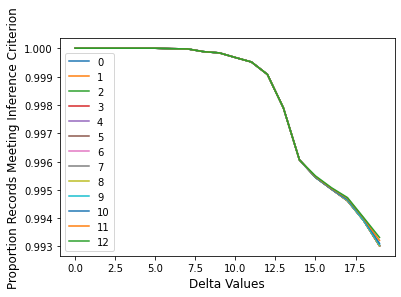

In [66]:
ax = proportion_meeting_inference.plot()
ax.set_ylabel('Proportion Records Meeting Inference Criterion', fontsize=12)
ax.set_xlabel('Delta Values', fontsize=12)
# legend shows different values of c - 0.01 to 0.09
plt.show()

The vast majority of points meet the inference criterion for any value of $c >= 0.02$. When $c = 0.01$, we have many points not meeting the criterion for most values of $\delta$. The problem with $c = 0.01$ is that the prior probability of living is approximately .988. If all points within the $\delta$ neighborhood lived, then the updated probability is 1, and the ratio is 1/.998 which is approximately 1.012.

***

# Legal Anonymization Algorithm

Function to determine which points violate any of the specified criteria.

Keep things simple. For each record,

* check whether the linkability criterion is met (if there is one).
    * If it isn't, generate new records to meet it.
* check whether the singling out criteria is met
    * The first criterion
    * The second criterion if there was no linkability criterion
* check whether inference criterion is met

In [67]:
# GMM = GaussianMixture(700, n_init=5).fit(X.loc[:,["latitude", "longitude"]])

# Implement on a by-record basis

In [68]:
def legal_anonymizer(original_data, synthetic_data, mixture_model, deltas, linkability, inference, prior_prob):
    
    # number of original records
    num_records = original_data.shape[0]
    
    # record percentages
    print_nums = [int(np.ceil(i*num_records)) for i in [0.25, 0.5, 0.75]]
    
    # random number generator
    rng = default_rng()
    
    # copy the synthetic dataset
    new_sX = synthetic_data
    
    # tree for synthetic locations
    sX_tree = cKDTree(new_sX[["latitude", "longitude"]])
    
    # store mixture component parameters
    mus = mixture_model.means_
    sigmas = mixture_model.covariances_
    
    # temporary count of the number of rows that violate one or more conditions
    violator_count = num_records
    
    # number of anonymization loops required
    num_loops = 1
    
    # while we have any violator rows
    while violator_count > 0:
        
        # reset violator count
        violator_count = 0
        
        # for each original record
        # we shuffle the records each time so that the violating records are fixed in a random order
        for i, original_record in original_data.sample(frac=1.0).reset_index(drop=True).iterrows():
            
            original_location = original_record.loc[["latitude", "longitude"]]
            original_categorical = original_record.loc[["sex", "age", "state"]]
            
            # for each delta
            for delta in deltas:
                
                ##### Test the Linkability Criterion
                
                # find synthetic neighbors based on location
                location_neighbors = sX_tree.query_ball_point(original_location, r=delta, p=2.0)
                
                # matches on categorical attributes from location neighbors
                categorical_matches = (new_sX.loc[location_neighbors,['sex', 'age', 'state']] == original_categorical).all(1)
                
                # count the number of synthetic records in the delta neighborhood with matching categorical attributes
                neighborhood_cardinality = np.sum(categorical_matches)
                
                ##### If the linkability criterion is violated,
                
                if (neighborhood_cardinality < linkability) and (neighborhood_cardinality > 0):
                    
                    # add one to number of violators
                    violator_count += 1
                    
                    # find the component with the highest responsibility for the confidential record
                    component_index = np.argmax(GMM.predict_proba(pd.DataFrame(original_location).T), axis = 1)[0]
                    current_mu = mus[component_index,:]
                    current_sigma = sigmas[component_index,:,:]
                    
                    # number of records needed to add
                    num_needed = linkability - neighborhood_cardinality
            
                    valid_candidates = np.zeros((0,2))
                    num_candidate_loops = 0
                    while valid_candidates.shape[0] < num_needed:
                        
                        # add a very small number to the diagonal of the covariance matrix to increase
                        # the likelihood of sampling candidate points - do this proportionally to the number
                        # of times this loop has executed
                        # np.fill_diagonal(current_sigma, np.diag(current_sigma) + num_candidate_loops*1e-6)
                        
                        # generate a bunch of candidate points
                        candidate_points = rng.multivariate_normal(current_mu, current_sigma, size=100000)
                        candidate_tree = cKDTree(candidate_points)
                        valid_indices = candidate_tree.query_ball_point(original_location, delta, p=2.0, return_sorted=True)
                        valid_candidates = np.vstack([valid_candidates, candidate_points[valid_indices,:]])
                        num_candidate_loops += 1
                        if num_candidate_loops > 100:
                            print('Stuck in linkability loop.')
                    
                    # select the number of needed candidates
                    new_locations = valid_candidates[:num_needed,:]
                    
                    new_categorical = np.vstack([np.array(original_categorical).reshape(1,-1) for k in range(num_needed)])
                    
                    new_records = pd.DataFrame(np.hstack([new_locations, new_categorical]))
                    
                    new_records.columns = new_sX.columns 
                    
                    new_sX = pd.concat([new_sX, new_records], axis=0).reset_index(drop=True)
                    
                    # rebuild the tree for synthetic locations
                    sX_tree = cKDTree(new_sX[["latitude", "longitude"]])
                    
                ##### Test the Inference Criterion
                
                # find synthetic neighbors based on location
                location_neighbors = sX_tree.query_ball_point(original_location, r=delta, p=2.0)
                
                # matches on categorical attributes from location neighbors
                categorical_matches = (new_sX.loc[location_neighbors,['sex', 'age']] == original_categorical[["sex", "age"]]).all(1)
                
                matching_rows = new_sX.loc[location_neighbors,:].loc[categorical_matches.values,:]
                
                # if there are any records in the location neighborhood that match on sex and age
                
                if matching_rows.shape[0] > 0:
                
                    if original_categorical['state'] == 1.0:
                        prior = prior_prob
                    else:
                        prior = 1-prior_prob
                        
                    num_matching = np.sum(matching_rows['state'] == original_categorical['state'])
            
                    cond = num_matching/matching_rows.shape[0] * 1/prior
                
                    if cond > inference:
                        
                        # add one to number of violators
                        violator_count += 1
                        
                        # number of records with non-matching sensitive variable needed to meet inference
                        num_needed = int(np.ceil(num_matching/(prior*inference) - matching_rows.shape[0]))
                        
                        # find the component with the highest responsibility for the confidential record
                        component_index = np.argmax(GMM.predict_proba(pd.DataFrame(original_location).T), axis = 1)[0]
                        current_mu = mus[component_index,:]
                        current_sigma = sigmas[component_index,:,:]
            
                        valid_candidates = np.zeros((0,2))
                        num_candidate_loops = 0
                        while valid_candidates.shape[0] < num_needed:
                        
                            # add a very small number to the diagonal of the covariance matrix to increase
                            # the likelihood of sampling candidate points - do this proportionally to the number
                            # of times this loop has executed
                            # np.fill_diagonal(current_sigma, np.diag(current_sigma) + num_candidate_loops*1e-6)
                        
                            # generate a bunch of candidate points
                            candidate_points = rng.multivariate_normal(current_mu, current_sigma, size=100000)
                            candidate_tree = cKDTree(candidate_points)
                            valid_indices = candidate_tree.query_ball_point(original_location, delta, p=2.0, return_sorted=True)
                            valid_candidates = np.vstack([valid_candidates, candidate_points[valid_indices,:]])
                            num_candidate_loops += 1
                            if num_candidate_loops > 100:
                                print('Stuck in inference loop.')
                            
                        # print(num_candidate_loops)
                    
                        # select the number of needed candidates
                        new_locations = valid_candidates[:num_needed,:]
                    
                        new_categorical = np.vstack([np.array(original_categorical).reshape(1,-1) for k in range(num_needed)])
                    
                        new_records = pd.DataFrame(np.hstack([new_locations, new_categorical]))
                    
                        new_records.columns = new_sX.columns
                        
                        new_records['state'] = 1.0 - original_categorical['state']
                    
                        new_sX = pd.concat([new_sX, new_records], axis=0).reset_index(drop=True)
                    
                        # rebuild the tree for synthetic locations
                        sX_tree = cKDTree(new_sX[["latitude", "longitude"]])
                    
                    
                    
        
#                     # put in a break statement - if we executed the previous code conditional on the if statement,
#                     # we know the linkability criterion is satisfied for all larger delta values for this record
#                     break
    
            if int(i) in print_nums:
                print("Record " + str(i) + " completed.")
                
        print("Full anonymization loop " + str(num_loops) + " completed.")
        
        num_loops += 1
                    
    return new_sX
            
                # test linkability criterion
                
                # if linkability criterion is violated
                
                    # add one to violator count (tells us we need to loop over all records again)
                
                    # generate new points to meet the criterion
                    
                # test inference criterion
                
                # if inference criterion is violated
                    
                    # add one to violator count (tells us we need to loop over all records again)
                    
                    # generate new points to meet the criterion

In [69]:
# new_sX = legal_anonymizer(original_data=X, synthetic_data=sXs[0], mixture_model=GMM, deltas=[target_delta], linkability=cutoff, inference=1.05, prior_prob=prior_death_prob)

In [70]:
# X.shape

In [71]:
# new_sX.shape

In [72]:
c = 0.25

In [73]:
new_sXs = []
for m,sX in enumerate(sXs):
    new_sX = legal_anonymizer(original_data=X, synthetic_data=sX, mixture_model=GMM, deltas=[target_delta], linkability=cutoff, inference=1 + c, prior_prob=prior_death_prob)
    new_sXs.append(new_sX)
    print("----------- Dataset " + str(m+1) + " Completed. -------------")

Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 3 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 4 completed.
----------- Dataset 1 Completed. -------------
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 3 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 4 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 5 completed.

Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 4 completed.
----------- Dataset 18 Completed. -------------
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 3 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 4 completed.
----------- Dataset 19 Completed. -------------
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 3 completed.
----------- Dataset 20 Completed. -------------


In [74]:
# [any_identical(X, Y) for Y in new_sXs]

In [75]:
neighbor_stats = [neighbor_finder(X, Y, deltas) for Y in new_sXs]

In [76]:
match_nums = [pd.concat(x, axis=1) for x in neighbor_stats]

In [77]:
match_nums = np.dstack(match_nums)

Calculate the number of singled-out records based on each synthetic dataset and each value of $\delta$. Rows are $\delta$ values and columns are synthetic datasets.

In [78]:
pct_singled_out = np.sum(match_nums == 1.0, axis=0)/X.shape[0]

In [79]:
avg_pct_singled_out = np.mean(pct_singled_out, axis=1)

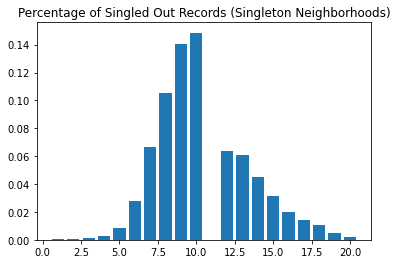

In [80]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_singled_out, align='center')
plt.title("Percentage of Singled Out Records (Singleton Neighborhoods)")
plt.show()

In [81]:
meet_cutoff = [[pd.concat([x == 0, x >= cutoff], axis=1).any(axis=1) for x in y] for y in neighbor_stats]

In [82]:
meet_cutoff = [pd.concat(x, axis=1) for x in meet_cutoff]

In [83]:
meet_cutoff = np.dstack(meet_cutoff)

In [84]:
pct_meet_cutoff = np.mean(meet_cutoff, axis=0)

In [85]:
avg_pct_meet_cutoff = pct_meet_cutoff.mean(axis=1)

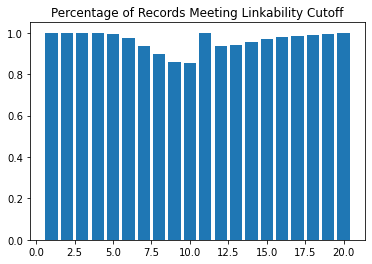

In [86]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_meet_cutoff, align='center')
plt.title("Percentage of Records Meeting Linkability Cutoff")
plt.show()

Now test for Inference criterion.

In [87]:
inference_conditions = [inference_evaluation(X, Y, prior_death_prob, deltas) for Y in new_sXs]

In [88]:
inf_conds = [pd.concat(x, axis=1) for x in inference_conditions]

In [89]:
proportion_meeting_inference = [[x <= (1 + c) for x in inf_conds] for c in c_vec]

In [90]:
proportion_meeting_inference = pd.concat([pd.concat([x.mean(axis=0) for x in y], axis=1).mean(axis=1) for y in proportion_meeting_inference], axis=1)

In [91]:
proportion_meeting_inference

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993,0.999993
6,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918,0.999918
7,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881,0.999881
8,0.999769,0.999769,0.999769,0.999769,0.999769,0.999769,0.999769,0.999769,0.999769,0.999769,0.999784,0.999784,0.999784
9,0.999680,0.999680,0.999680,0.999680,0.999680,0.999680,0.999680,0.999680,0.999680,0.999687,0.999769,0.999873,0.999933


Display the average proportion of records meeting the inference criterion across all synthetic datasets for each combination of $\delta$ and $c$.

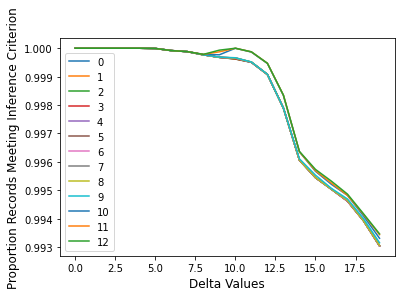

In [92]:
ax = proportion_meeting_inference.plot()
ax.set_ylabel('Proportion Records Meeting Inference Criterion', fontsize=12)
ax.set_xlabel('Delta Values', fontsize=12)
# legend shows different values of c - 0.01 to 0.09
plt.show()

## Now save all anonymized synthetic datasets.

In [93]:
for i, sX in enumerate(new_sXs):
    sX.to_csv("Data/synthetic_datasets/anonymized_synthetic_dataset_" + str(i) + ".csv", index=False)

In [2]:
104/8897 * 85.548077

1.0000000008991796